# Deep Cross Correlation between EEG and BOLD signal

#### GOAL: perform convolution among bands and channels for each timestep, with non linear activations, in order to have a signal of the same length as the BOLD signal and correlate them

#### The loss will be the inverse cross correlation between the activation signal and BOLD signal

In [15]:
import sys
sys.path.append("..")

import eeg_utils
import fmri_utils

import numpy as np
from numpy import correlate

import matplotlib.pyplot as plt

import mne
from nilearn.masking import apply_mask, compute_epi_mask

from sklearn.preprocessing import normalize

from scipy.signal import resample

In [36]:
X = []
y = []

start_cutoff = 3

TR = 1/2.160

for individual in range(16):
    eeg = eeg_utils.get_eeg_instance(individual)
    x_instance = []
    #eeg
    for channel in range(len(eeg.ch_names)):
        f, Zxx, t = eeg_utils.stft(eeg, channel=channel, window_size=2)
        x_instance += [eeg_utils.mutate_stft_to_bands(Zxx, f, t)[:,:321]]
    
    #fmri
    fmri_masked_instance = fmri_utils.get_fmri_instance(individual)
    #for voxel in range(fmri_masked_instance.shape[1]):
    for voxel in range(100):
        voxel = fmri_utils.get_voxel(fmri_masked_instance, voxel=voxel)
        voxel_resampled = resample(voxel, int((len(voxel)*(1/2))/TR))

        X += [x_instance]
        y += [voxel_resampled[start_cutoff:]]
    
    break

X = np.array(X)
y = np.array(y)

Extracting parameters from /home/david/eeg_informed_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...


../eeg_utils.py:35: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True)


#### Lack of data, due to only having space for 100 instances:

Our dataset has multiple X instances being equal with different target y

### Defining our network

In [58]:
import keras

from keras.models import Sequential
from keras.layers import Conv3D, Flatten
from keras.optimizers import Adam
from keras.losses import mae

import keras.backend as K

X = X.reshape(X.shape[0], X.shape[1], X.shape[2], X.shape[3], 1)

input_shape = (X.shape[1], X.shape[2], X.shape[3], 1)

kernel_size = (X.shape[1], X.shape[2], 1)

model = Sequential()

model.add(Conv3D(1, kernel_size=(64, 5, 1),
                 activation='relu',
                 input_shape=input_shape))

model.add(Flatten())

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 1, 1, 321, 1)      321       
_________________________________________________________________
flatten_5 (Flatten)          (None, 321)               0         
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
None


### Let's define a cross correlation loss

In [59]:
def cross_correlation(x, y):
    
    #how should the normalization be done??
    x = K.l2_normalize(x, axis=1)
    y = K.l2_normalize(y, axis=1)

    a = K.batch_dot(x, y, axes=1)

    b = K.batch_dot(x, x, axes=1)
    c = K.batch_dot(y, y, axes=1)

    return 1 - (a / (K.sqrt(b) * K.sqrt(c)))

model.compile(loss=cross_correlation, optimizer=Adam())

## Finally train and see if it converges

In [62]:
history = model.fit(X, y, epochs=100, verbose=0)

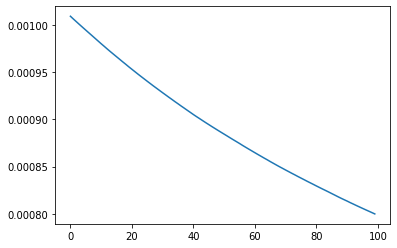

In [65]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.show()

## Extract the activations and plot the cross-correlation coefficients

In [66]:
eeg_embeddings = model.predict(X)

In [86]:
deep_corr = correlate(eeg_embeddings[0], y[0])
linear_corr = correlate(X[0][0][0].reshape(1,-1)[0], y[0])
print(deep_corr, linear_corr)

[7648.1280569] [1653.00731895]
